In [151]:
from pathlib import Path
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
import keras_preprocessing

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from imblearn.combine import SMOTEENN

print(tf.config.list_physical_devices("GPU"))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [152]:
def read_and_shuffle_data():
    full_data = pd.read_csv(Path().resolve().joinpath("dataset/full_data.csv"))

    shuffled = full_data.sample(frac=1, random_state=0)

    return shuffled


def encode_int(
    data: pd.DataFrame, enc: OrdinalEncoder, categorical_features: list[str]
):
    data_categorical = data[categorical_features].copy()

    enc.fit(data_categorical)

    data[data_categorical.columns] = enc.fit_transform(data_categorical)

    return data


def decode_int(
    data: pd.DataFrame, enc: OrdinalEncoder, categorical_features: list[str]
):
    data_categorical = data[categorical_features].copy()

    data[data_categorical.columns] = enc.inverse_transform(data_categorical)

    return data


def impute_missing(data: DataFrame, header):
    # enc = OrdinalEncoder()
    # enc.fit(data)

    imputer = KNNImputer(n_neighbors=2, missing_values=np.nan, weights="uniform")
    # imputed_data = imputer.fit_transform(enc.transform(data))
    imputed_data = imputer.fit_transform(data)

    # smoking_status = DataFrame(enc.inverse_transform(smoking_status), columns=header)
    imputed_data = DataFrame(imputed_data, columns=header)

    return imputed_data


def resample(data: pd.DataFrame):
    """oversample positive cases with SMOTE and undersample negative with EEN"""
    # enc = OrdinalEncoder()
    # enc.fit(data)

    # data = DataFrame(enc.transform(data), columns=data.columns)

    X = data.drop(columns=["stroke"], axis=1)
    Y = data["stroke"]

    smote_een = SMOTEENN(random_state=0, sampling_strategy="auto")

    # x_resampled, y_resampled = smote_een.fit_resample(X, Y)
    x_resampled, y_resampled = smote_een.fit_resample(X, Y)
    x_resampled["stroke"] = y_resampled

    # return DataFrame(enc.inverse_transform(x_resampled), columns=data.columns)
    return DataFrame(x_resampled, columns=data.columns)


def generate_train_valid_test(shuffled_data_df: DataFrame):
    test_set = shuffled_data_df[4500:]

    train_validation_data = shuffled_data_df[:4500].sample(frac=1, random_state=0)

    train_set = resample(train_validation_data[:4000])
    validation_set = train_validation_data[4000:]

    return train_set, validation_set, test_set


def prepare_data_tvt(header, categorical_features):
    full_data_shuffled = read_and_shuffle_data()

    full_data_shuffled[
        ["hypertension", "heart_disease", "ever_married", "smoking_status"]
    ] = full_data_shuffled[
        [
            "hypertension",
            "heart_disease",
            "ever_married",
            "smoking_status",
        ]
    ].replace(
        {1: "Yes", 0: "No", "Unknown": np.nan}
    )  # ensure they don't interfere with StringLookupLayers later

    # encode the categorical features before resampling and imputing
    enc = OrdinalEncoder()
    full_data_shuffled = encode_int(
        data=full_data_shuffled, enc=enc, categorical_features=categorical_features
    )

    full_data_shuffled = impute_missing(
        full_data_shuffled, header=full_data_shuffled.columns
    )

    train_df, validation_df, test_df = generate_train_valid_test(full_data_shuffled)

    # decode the categorical features from ints
    train_df, validation_df, test_df = [
        decode_int(data=df, enc=enc, categorical_features=categorical_features)
        for df in [train_df, validation_df, test_df]
    ]

    test_df.to_csv(
        Path().resolve().joinpath("dataset/test_data.csv"), index=False, header=False
    )

    validation_df.to_csv(
        Path().resolve().joinpath("dataset/validation_data.csv"),
        index=False,
        header=False,
    )

    train_df.to_csv(
        Path().resolve().joinpath("dataset/train_data.csv"), index=False, header=False
    )

    return test_df, train_df, validation_df


In [153]:
# prepare data
CSV_HEADER = [
    "gender",
    "age",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "residence_type",
    "avg_glucose_level",
    "bmi",
    "smoking_status",
    "stroke",
]

NUMERIC_FEATURE_NAMES = [
    "age",
    "avg_glucose_level",
    "bmi",
]  # list of numeric feature names

CATEGORICAL_FEATURE_NAMES = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "residence_type",
    "smoking_status",
]

train_data_path = Path().resolve().joinpath("dataset/train_data.csv")
validation_data_path = Path().resolve().joinpath("dataset/validation_data.csv")
test_data_path = Path().resolve().joinpath("dataset/test_data.csv")

train_data_file = str(train_data_path.absolute())
validation_data_file = str(validation_data_path.absolute())
test_data_file = str(test_data_path.absolute())

train_data = DataFrame()
validation_data = DataFrame()
test_data = DataFrame()

try:
    train_data = pd.read_csv(
        Path().resolve().joinpath("dataset/train_data.csv"), names=CSV_HEADER
    )

    validation_data = pd.read_csv(
        Path().resolve().joinpath("dataset/validation_data.csv"), names=CSV_HEADER
    )

    test_data = pd.read_csv(
        Path().resolve().joinpath("dataset/test_data.csv"), names=CSV_HEADER
    )

except:
    test_data, train_data, validation_data = prepare_data_tvt(header=CSV_HEADER, categorical_features=CATEGORICAL_FEATURE_NAMES)

test_data, train_data, validation_data = prepare_data_tvt(header=CSV_HEADER, categorical_features=CATEGORICAL_FEATURE_NAMES)

print(
    f"Using {len(train_data)} samples for training, {len(validation_data)} for validation, and {len(test_data)} for test"
)

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "gender": sorted(list(train_data["gender"].unique())),
    "hypertension": sorted(list(train_data["hypertension"].unique())),
    "heart_disease": sorted(list(train_data["heart_disease"].unique())),
    "ever_married": sorted(list(train_data["ever_married"].unique())),
    "work_type": sorted(list(train_data["work_type"].unique())),
    "residence_type": sorted(list(train_data["residence_type"].unique())),
    "smoking_status": sorted(list(train_data["smoking_status"].unique())),
}

# metadata
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# The name of the target feature.
TARGET_FEATURE_NAME = "stroke"
# A list of the labels of the target features.
TARGET_LABELS = ["Yes", "No"]

MLP_MODEL_PATH = str(Path().resolve().joinpath("model/mlp_model"))
TABTRANSFORMER_MODEL_PATH = str(Path().resolve().joinpath("model/tabtransformer_model"))

Using 6468 samples for training, 500 for validation, and 481 for test


/tmp/ipykernel_126373/1048641975.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data_categorical.columns] = enc.inverse_transform(data_categorical)


In [154]:
# model hyperparameters

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.1
BATCH_SIZE = 32
NUM_EPOCHS = 100
EPOCHS_TO_WAIT_FOR_IMPROVE = 5

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.


In [155]:
# data proccessing pipeline

target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    #target_index = target_label_lookup(target)
    target_index = target
    return features, target_index


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    """dataset from, csv"""
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()


/home/haoming/.local/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [156]:
def create_model_inputs():
    """Create model inputs"""
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs


def encode_inputs(inputs, embedding_dims):
    """Encode features"""

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    print(encoded_categorical_feature_list)

    return encoded_categorical_feature_list, numerical_feature_list


In [157]:
# training and evaluation


def run_experiment(
    model: keras.Model,
    train_data_file,
    test_data_file,
    model_output,
    num_epochs,
    EPOCHS_TO_WAIT_FOR_IMPROVE,
    learning_rate,
    batch_size,
):
    """Implement a training and evaluation procedure"""
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=WEIGHT_DECAY
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)


    # early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=EPOCHS_TO_WAIT_FOR_IMPROVE)
    # checkpoint_callback = keras.callbacks.ModelCheckpoint(model_output, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    metrics=[
        keras.metrics.BinaryAccuracy(name='acc'),
        keras.metrics.AUC(name='auc'),
    ],

    early_stop_callback = keras.callbacks.EarlyStopping(
        monitor="val_auc", patience=EPOCHS_TO_WAIT_FOR_IMPROVE
    )

    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        model_output,
        monitor="val_auc",
        verbose=1,
        save_best_only=True,
        mode="max",
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics,
    )

    print("Start training the model...")

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=validation_dataset,
        callbacks=[checkpoint_callback, early_stop_callback],
    )

    print("Model training finished")

    _, accuracy, auc = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}% AUC: {auc}")

    return history, model


In [158]:
# MLP block
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    """MLP block"""

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)


def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):
    """MLP model without transformer layers"""

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.relu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


[<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_98')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_99')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_100')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_101')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_102')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_103')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_104')>]
Total model weights: 68115


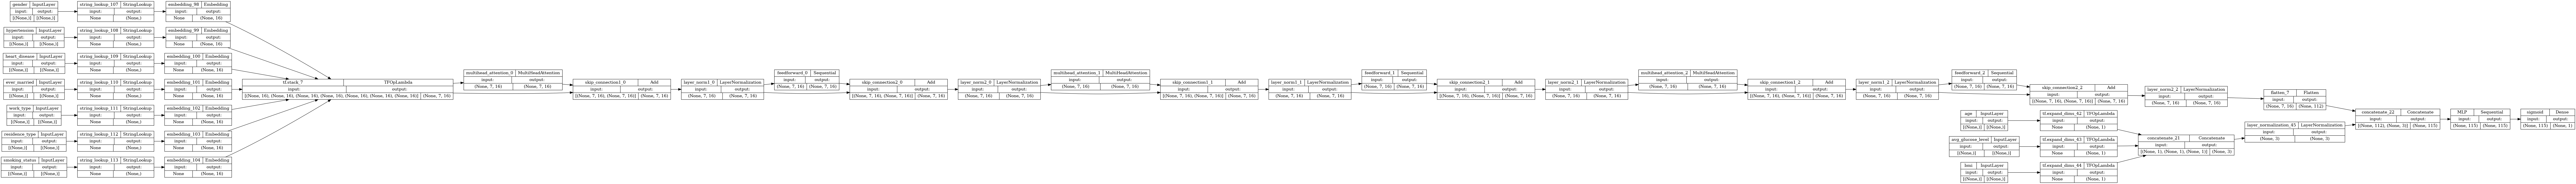

In [159]:
# tabtransformer block


def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = tf.range(start=0, limit=num_columns, delta=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
    # use_column_embedding=True
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")


/home/haoming/.local/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


[<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_105')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_106')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_107')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_108')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_109')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_110')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_111')>]
Total model weights: 81233


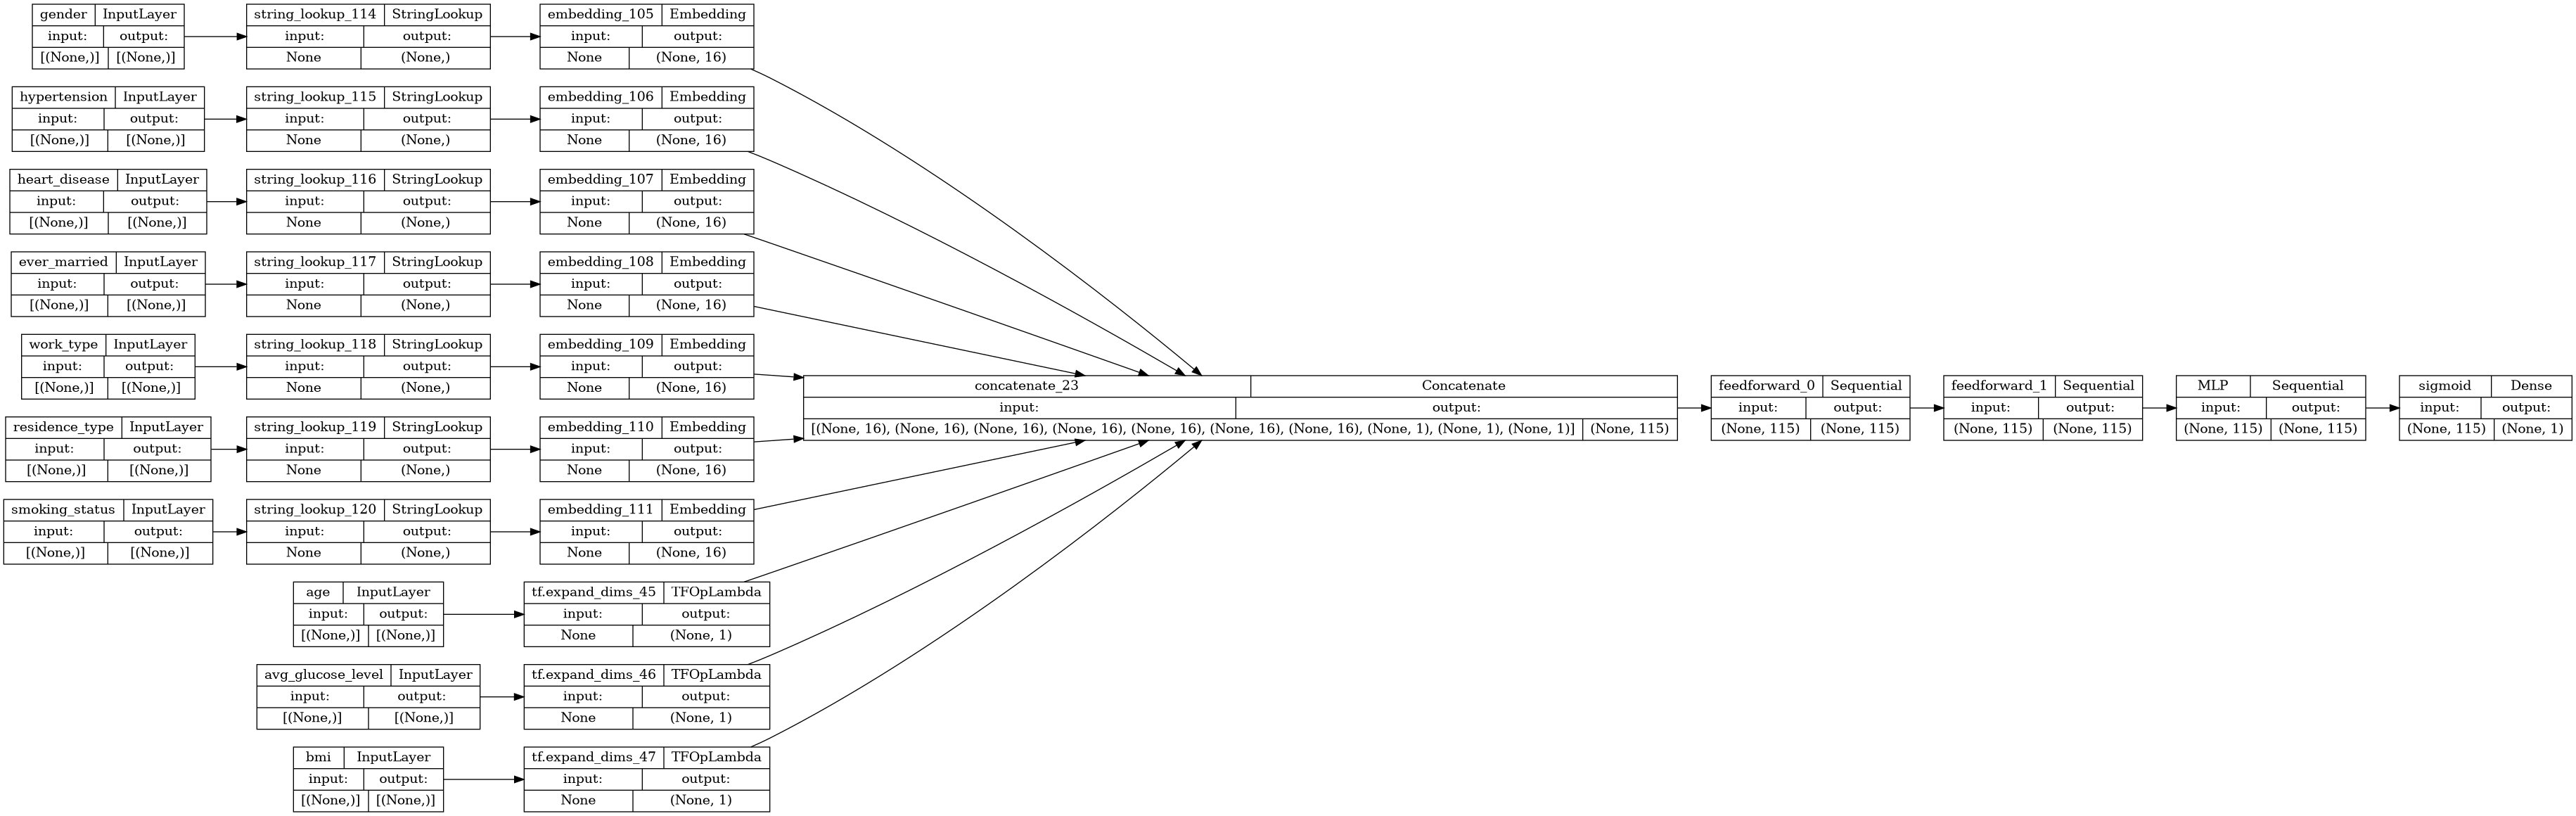

In [160]:
# define a baseline model without transformer layer

baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")


In [167]:
# train baseline model with training set and evaluate with validation set

history, mlp_trained_training = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=validation_data_file,
    model_output=MLP_MODEL_PATH,
    num_epochs=NUM_EPOCHS,
    EPOCHS_TO_WAIT_FOR_IMPROVE=EPOCHS_TO_WAIT_FOR_IMPROVE,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
)



TypeError: run_experiment() got an unexpected keyword argument 'EPOCHS_TO_WAIT_FOR_IMPROVE'

In [162]:
# Now, train on validation set and evalate with test set

history, mlp_trained_validation = run_experiment(
    model=mlp_trained_training,
    train_data_file=validation_data_file,
    test_data_file=test_data_file,
    model_output=MLP_MODEL_PATH,
    num_epochs=NUM_EPOCHS,
    EPOCHS_TO_WAIT_FOR_IMPROVE=EPOCHS_TO_WAIT_FOR_IMPROVE,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
)


Start training the model...
Epoch 1/100
     13/Unknown - 5s 14ms/step - loss: 0.4762 - acc: 0.8173 - auc: 0.6979
Epoch 1: val_auc improved from -inf to 0.54852, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model
INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets


16/16 [==============================] - 11s 433ms/step - loss: 0.4472 - acc: 0.8340 - auc: 0.6631 - val_loss: 0.6159 - val_acc: 0.9397 - val_auc: 0.5485
Epoch 2/100
13/16 [=======================>......] - ETA: 0s - loss: 0.2405 - acc: 0.9303 - auc: 0.7227
Epoch 2: val_auc improved from 0.54852 to 0.72879, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model
INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets


16/16 [==============================] - 6s 383ms/step - loss: 0.2382 - acc: 0.9280 - auc: 0.7417 - val_loss: 0.3469 - val_acc: 0.9397 - val_auc: 0.7288
Epoch 3/100
13/16 [=======================>......] - ETA: 0s - loss: 0.2307 - acc: 0.9303 - auc: 0.7690
Epoch 3: val_auc improved from 0.72879 to 0.72936, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model
INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets


16/16 [==============================] - 5s 347ms/step - loss: 0.2280 - acc: 0.9280 - auc: 0.7850 - val_loss: 0.3127 - val_acc: 0.9397 - val_auc: 0.7294
Epoch 4/100
14/16 [=========================>....] - ETA: 0s - loss: 0.2089 - acc: 0.9330 - auc: 0.7915
Epoch 4: val_auc improved from 0.72936 to 0.75587, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model
INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets


16/16 [==============================] - 6s 411ms/step - loss: 0.2131 - acc: 0.9280 - auc: 0.8104 - val_loss: 0.2658 - val_acc: 0.9397 - val_auc: 0.7559
Epoch 5/100
13/16 [=======================>......] - ETA: 0s - loss: 0.2291 - acc: 0.9303 - auc: 0.7515
Epoch 5: val_auc improved from 0.75587 to 0.80420, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model
INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets


16/16 [==============================] - 5s 359ms/step - loss: 0.2226 - acc: 0.9280 - auc: 0.7839 - val_loss: 0.2203 - val_acc: 0.9397 - val_auc: 0.8042
Epoch 6/100
14/16 [=========================>....] - ETA: 0s - loss: 0.2131 - acc: 0.9330 - auc: 0.7731
Epoch 6: val_auc did not improve from 0.80420
16/16 [==============================] - 0s 19ms/step - loss: 0.2156 - acc: 0.9280 - auc: 0.7954 - val_loss: 0.2264 - val_acc: 0.9397 - val_auc: 0.7981
Epoch 7/100
15/16 [===========================>..] - ETA: 0s - loss: 0.2149 - acc: 0.9271 - auc: 0.8048
Epoch 7: val_auc did not improve from 0.80420
16/16 [==============================] - 0s 18ms/step - loss: 0.2150 - acc: 0.9280 - auc: 0.7988 - val_loss: 0.2166 - val_acc: 0.9397 - val_auc: 0.7895
Epoch 8/100
15/16 [===========================>..] - ETA: 0s - loss: 0.2140 - acc: 0.9271 - auc: 0.8051
Epoch 8: val_auc did not improve from 0.80420
16/16 [==============================] - 0s 20ms/step - loss: 0.2121 - acc: 0.9280 - auc: 0.8

In [163]:
# train tabtransformer model on training data and evaluate on validation data

history, tt_trained_training = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=validation_data_file,
    model_output=TABTRANSFORMER_MODEL_PATH,
    num_epochs=NUM_EPOCHS,
    EPOCHS_TO_WAIT_FOR_IMPROVE=15,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
)


Start training the model...
Epoch 1/100
    203/Unknown - 12s 22ms/step - loss: 0.5387 - acc: 0.7495 - auc: 0.8169
Epoch 1: val_auc improved from -inf to 0.69196, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


203/203 [==============================] - 24s 84ms/step - loss: 0.5387 - acc: 0.7495 - auc: 0.8169 - val_loss: 0.5830 - val_acc: 0.6980 - val_auc: 0.6920
Epoch 2/100
201/203 [============================>.] - ETA: 0s - loss: 0.4801 - acc: 0.7730 - auc: 0.8442
Epoch 2: val_auc did not improve from 0.69196
203/203 [==============================] - 5s 23ms/step - loss: 0.4799 - acc: 0.7733 - auc: 0.8442 - val_loss: 0.7207 - val_acc: 0.6460 - val_auc: 0.6822
Epoch 3/100
203/203 [==============================] - ETA: 0s - loss: 0.4490 - acc: 0.7908 - auc: 0.8611
Epoch 3: val_auc did not improve from 0.69196
203/203 [==============================] - 5s 23ms/step - loss: 0.4490 - acc: 0.7908 - auc: 0.8611 - val_loss: 0.5459 - val_acc: 0.6960 - val_auc: 0.6548
Epoch 4/100
201/203 [============================>.] - ETA: 0s - loss: 0.4341 - acc: 0.7984 - auc: 0.8678
Epoch 4: val_auc did not improve from 0.69196
203/203 [==============================] - 5s 23ms/step - loss: 0.4334 - acc: 0.7

In [164]:
# Now, train tabtransformer model on validation data and evaluate on test data

history, tt_trained_validation = run_experiment(
    model=tt_trained_training,
    train_data_file=validation_data_file,
    test_data_file=test_data_file,
    model_output=TABTRANSFORMER_MODEL_PATH,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
)


Start training the model...
Epoch 1/100
     15/Unknown - 8s 24ms/step - loss: 0.4529 - acc: 0.7917 - auc: 0.5530
Epoch 1: val_auc improved from -inf to 0.44065, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


16/16 [==============================] - 21s 878ms/step - loss: 0.4535 - acc: 0.7940 - auc: 0.5429 - val_loss: 0.2936 - val_acc: 0.9252 - val_auc: 0.4406
Epoch 2/100
15/16 [===========================>..] - ETA: 0s - loss: 0.2559 - acc: 0.9250 - auc: 0.6816
Epoch 2: val_auc improved from 0.44065 to 0.73871, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


16/16 [==============================] - 13s 856ms/step - loss: 0.2627 - acc: 0.9220 - auc: 0.6812 - val_loss: 0.2298 - val_acc: 0.9293 - val_auc: 0.7387
Epoch 3/100
14/16 [=========================>....] - ETA: 0s - loss: 0.2543 - acc: 0.9062 - auc: 0.7266
Epoch 3: val_auc improved from 0.73871 to 0.75092, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


16/16 [==============================] - 13s 894ms/step - loss: 0.2491 - acc: 0.9100 - auc: 0.7295 - val_loss: 0.2228 - val_acc: 0.9335 - val_auc: 0.7509
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.2051 - acc: 0.9240 - auc: 0.8364
Epoch 4: val_auc did not improve from 0.75092
16/16 [==============================] - 1s 39ms/step - loss: 0.2051 - acc: 0.9240 - auc: 0.8364 - val_loss: 0.2186 - val_acc: 0.9314 - val_auc: 0.7426
Epoch 5/100
15/16 [===========================>..] - ETA: 0s - loss: 0.2170 - acc: 0.9292 - auc: 0.7851
Epoch 5: val_auc improved from 0.75092 to 0.76686, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


16/16 [==============================] - 13s 875ms/step - loss: 0.2184 - acc: 0.9260 - auc: 0.8005 - val_loss: 0.2155 - val_acc: 0.9335 - val_auc: 0.7669
Epoch 6/100
15/16 [===========================>..] - ETA: 0s - loss: 0.2014 - acc: 0.9312 - auc: 0.8130
Epoch 6: val_auc did not improve from 0.76686
16/16 [==============================] - 1s 40ms/step - loss: 0.2026 - acc: 0.9280 - auc: 0.8276 - val_loss: 0.2159 - val_acc: 0.9314 - val_auc: 0.7563
Epoch 7/100
15/16 [===========================>..] - ETA: 0s - loss: 0.1942 - acc: 0.9292 - auc: 0.8502
Epoch 7: val_auc did not improve from 0.76686
16/16 [==============================] - 1s 42ms/step - loss: 0.2012 - acc: 0.9260 - auc: 0.8447 - val_loss: 0.2199 - val_acc: 0.9376 - val_auc: 0.7218
Epoch 8/100
16/16 [==============================] - ETA: 0s - loss: 0.2064 - acc: 0.9280 - auc: 0.8383
Epoch 8: val_auc did not improve from 0.76686
16/16 [==============================] - 1s 51ms/step - loss: 0.2064 - acc: 0.9280 - auc: 0.